# Deep Reinforcement Learning on 98Cards

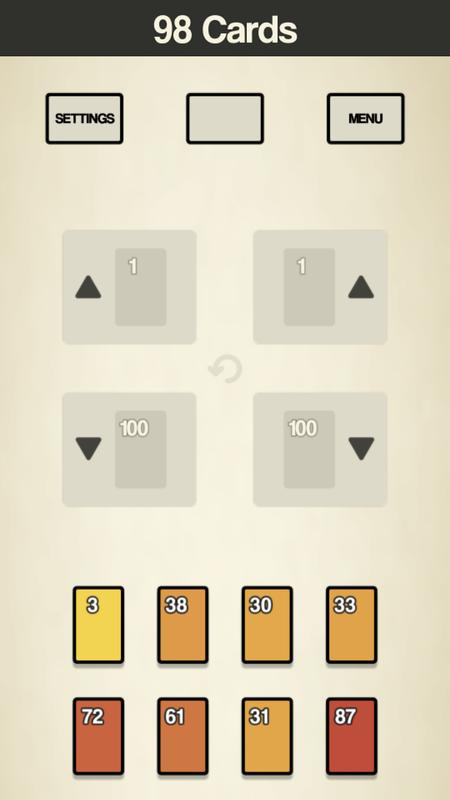

98 Cards is a simple solitaire-esque game. The objective is to play all 98 cards (which are numbered 2-99) onto the 4 stacks. Two of the stacks only let you play a card greater than the previously played card, and the other two only let you play a card less than the previously played card. The kicker is that is that if the difference between two cards on the stack is exactly 10, it can be played on that stack regardless of whether its greater or less than the card on the stack. 

In this notebook I implement an AI that learns to play 98 cards using Deep Reinforcement Learning. The file n8Cards contains a barebones version of the game programmed by me. The reward function used is: -100 for an invalid move, +n for a valid move where n is the number of cards played so far. This incentives the AI to play the most cards it can. 

First, we import some necessary tools. Numpy helps with some processing along the way and Tensorflow does most of the work. 

In [ ]:
import numpy as np
import tensorflow as tf
import n8Cards

In [ ]:
#global variables
stateSize = 13 #4 piles, 8 cards, cardsRemaining
actionSize = 32 #4 piles x 8 cards

#training variables, these can all be adjusted to get different results
gamma = .95
learning_rate = .003
trainingSize = 100000
epsilon = .0001

Here I define some helper functions. The first turns our game state into a numpy array so it can be inputted into the neural network.

The second turns our actionList into a vector where the i'th input is 1 if that action is playable. We use the resulting vector to elementwise multiply the output of our neural net so it only allows us to play valid actions.

Normally, a softmax on the result of the neural network would return a nice distribution, but we filtered out a lot of the output, so there are weird edge cases where we take the softmax of a small number of small values, or all negative values. After being softmaxed, this leads to the value zero having a large weight after being softmaxed and causes us to play invalid moves. We define this function so we can filter out the invalid actions and scale the values appropriately so our softmax function only returns a distribution over the valid actions.

In [ ]:
def boardToVec(curBoard):
    O = (curBoard.observable)
    O.sort()
    V = [curBoard.cardsRemaining]+O
    return np.array(V)

a = nnCards.Board(1)
print(boardToVec(a))

In [ ]:
def actionsToVec(actionList):
    result = np.zeros(actionSize)
    for (stack,card) in actionList:
        result[stack*8+card] = 1
    return result

actionsToVec([(3,7)])

In [ ]:
def filterAssistant(V):
    L = list(list(V)[0])
    allNeg = True
    for x in L:
        if x > epsilon:
            allNeg = False
            break
    if allNeg:
        return V*-100000000000.0
    else:
        return V*100000000000.0

Next we have our neural net, it takes in a vector of size 13 and pushes it through 5 fully connected layers. The first four all use a relu activation function, and the last one uses a tanh activation function because we don't want valid moves to have a 0 in their place, otherwise we might get a 0 vector after filtering invalid actions. 

In [ ]:
inputs = tf.placeholder(tf.float32, [None, stateSize], name = "inputs")

legalActions = tf.placeholder(tf.float32, [None, actionSize], name = "legalActions")
actionsTaken = tf.placeholder(tf.float32, [None, actionSize], name = "actionsTaken")
discountedNormedRewards = tf.placeholder(tf.float32, [None, ], name = "discountedNormedRewards")


fcLayer1 = tf.contrib.layers.fully_connected(inputs = inputs, num_outputs = 48, activation_fn = tf.nn.relu,
                                             weights_initializer = tf.contrib.layers.xavier_initializer())


fcLayer2 = tf.contrib.layers.fully_connected(inputs = fcLayer1, num_outputs = 96, activation_fn = tf.nn.relu,
                                            weights_initializer = tf.contrib.layers.xavier_initializer())

fcLayer3 = tf.contrib.layers.fully_connected(inputs = fcLayer2, num_outputs = 192, activation_fn = tf.nn.relu,
                                            weights_initializer = tf.contrib.layers.xavier_initializer())

fcLayer4 = tf.contrib.layers.fully_connected(inputs = fcLayer3, num_outputs = 96, activation_fn = tf.nn.relu,
                                            weights_initializer = tf.contrib.layers.xavier_initializer())

fcLayer5 = tf.contrib.layers.fully_connected(inputs = fcLayer4, num_outputs = actionSize, activation_fn = tf.nn.tanh,
                                            weights_initializer = tf.contrib.layers.xavier_initializer())

filtered = tf.multiply(fcLayer5, legalActions)

filteredScaled = tf.py_func(filterAssistant, [filtered], tf.float32)

softmax = tf.nn.softmax(filteredScaled)

negLogProb = tf.nn.softmax_cross_entropy_with_logits_v2(logits = filtered, labels = actionsTaken)
loss = tf.reduce_mean(negLogProb * discountedNormedRewards)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)


Next we use Deep Reinforcement Learning to train the NN. The outline of what we do is below.

In [ ]:
maxScore = 0
allScores = []

actionList = []
stateList = []
rewards = []
possibleActions = []
totalRewards = []


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print('Starting Training')

for step in range(trainingSize):
    
    board = n8Cards.Board()
    
    actions = board.getActionList()
    
    while len(actions) != 0:
        #play the game, storing everything
        stateList.append(boardToVec(board).reshape([1,13]))
        
        feedDict =  {inputs: boardToVec(board).reshape([1,13]), legalActions: actionsToVec(actions).reshape(1, 32)}
        
        
        dist = sess.run(softmax,feed_dict = feedDict)
        
        possibleActions.append(actionsToVec(actions).reshape(1, 32))
        
        
        actionIndex = np.random.choice(range(dist.shape[1]), p=dist.ravel())
        
        actionVec = np.zeros(32)
        actionVec[actionIndex] = 1
        actionList.append(actionVec)
        
        card = actionIndex%8
        stack = actionIndex// 8
        
        reward = board.playAction(stack,card)
        rewards.append(reward)
        
        actions = board.getActionList()
        
    totalScore = np.sum(rewards)
    allScores.append(totalScore)    
        
    #OPTIMIZE

    averageRewards = np.mean(allScores)

    maxScore = np.max(allScores)

    #discounting+normalizing
    discountedRewards = np.zeros_like(rewards)
    cumulative = 0

    for i in reversed(range(len(rewards))):
        cumulative = cumulative * gamma + rewards[i]
        discountedRewards[i] = cumulative

    mean = np.mean(discountedRewards)
    std = np.std(discountedRewards)
    discountedRewards = (discountedRewards - mean) / (std)

    Oloss,_ = sess.run([loss, optimizer], feed_dict={inputs: np.vstack(np.array(stateList)),
                                                                 legalActions: np.array(possibleActions).reshape(len(possibleActions),32),
                                                                  actionsTaken: np.vstack(np.array(actionList)),
                                                                  discountedNormedRewards: discountedRewards})

    #Reset
    rewards = []
    stateList = []
    actionList = []
    possibleActions = []

    if step % 1000 == 999:
        print(np.mean(allScores[-500:]))
        print(maxScore)
    
    
sess.close()

Now we can use this model to have our machine play 98 Cards!

In [ ]:
def findAction(board, actions):  
    
    bV = boardToVec(board).reshape([1,13])
    
    feedDict =  {inputs: boardToVec(board).reshape([1,13]), legalActions: actionsToVec(actions).reshape(1, 32)}
           
    dist = sess.run(softmax,feed_dict = feedDict)
                
    actionIndex = np.random.choice(range(dist.shape[1]), p=dist.ravel())
    
    card = actionIndex%8
    stack = actionIndex// 8
    
    return card, stack

In [ ]:
def playGame(seed = 0):
    if seed == 0:
        board = n8Cards.Board()
    else:
        board = n8Cards.Board(seed)
        
    actions = board.getActionList()
    
    while len(actions) != 0:
        card, stack = findAction(board, actions)
        board.playAction(stack, card)
        actions = board.getActionList()
    return board.score
        
playGame()